<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/kalapa_4student_net2_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print(pd.__version__)
print(tf.__version__)

1.0.5
2.3.0


## Load data

In [3]:
submision_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/simple_submission.csv'
train_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/train.csv'
test_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/test.csv'

In [4]:
def load_data(train_path, test_path, label_col = 'label'):
    train_set = pd.read_csv(train_path)
    test_set = pd.read_csv(test_path)
    return train_set, test_set

train_set, test_set = load_data( train_path, test_path )
cols = train_set.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53030 entries, 0 to 53029
Columns: 195 entries, id to Field_82
dtypes: float64(133), int64(3), object(59)
memory usage: 78.9+ MB


### Data trasforming

In [6]:
# train_set[cols_categorical].head()
# train_set.Field_61.unique()

In [7]:
# len(train_set.Field_45.unique())
# cols_id

In [8]:
# len(train_set.homeTownCity.unique())

In [9]:
# train_set.Field_75.unique()
# train_set.homeTownCity.hist()
# print(cols_docs)

In [10]:
# train_set[cols_fts_num].head()

In [11]:
# Nhãn
cols_label = ['label']
# Đặc trưng binary
cols_fts_binary = [i for i in train_set.select_dtypes(include=['float64','int64']).columns 
                   if len(set(train_set[i].fillna(0)) - {0,1} ) == 0 and i not in cols_label]
# định dang datte yyyy-mm-dd
cols_date = ['Field_1','Field_2','Field_5','Field_6','Field_7','Field_8','Field_9','Field_10','Field_11'
             ,'Field_14','Field_15','Field_25','Field_32','Field_33','Field_34','Field_35','Field_40','Field_43','Field_44'
             ,'F_startDate','F_endDate','E_startDate','E_endDate','C_startDate','C_endDate','G_startDate','G_endDate'
             ,'A_startDate','A_endDate']
# định dạng date yyymmdd
cols_date2 = ['Field_33','ngaySinh']
# Đặc trưng dạng văn bản
cols_docs = ['Field_46','diaChi','Field_48','Field_49','currentLocationName','homeTownName','Field_56']
# Định danh bản ghi
cols_id = ['id','Field_45'] +[i for i in train_set.select_dtypes(include = ['object']).columns 
                              if len(train_set[i].unique()) >=350 and i not in cols_date + cols_date2+cols_docs]
# Đặc trưng dạng categorical
cols_categorical = [i for i in train_set.select_dtypes(include = ['object']).columns
                    if i not in cols_id + cols_label+cols_date2+cols_date+cols_docs]
# Đặc trưng số
cols_fts_num = [ i for i in test_set.select_dtypes(include=['float64','int64']).columns 
                if i not in cols_id + cols_label + cols_fts_binary + cols_date2+cols_date+cols_docs]

In [12]:
# cols_categorical

In [13]:
# Đặc trưng số có dạng như categorical
cols_num_like_cat = [i for i in cols_fts_num if len(train_set[i].unique()) <= 15 ]
# Đặc trưng số đã kiểm chứng
cols_num = [i for i in cols_fts_num if i not in cols_num_like_cat]

cols_categorical = cols_categorical + cols_num_like_cat
cols_fts_num = [i for i in cols_fts_num if i not in cols_num_like_cat ]

In [14]:
# for i in cols_fts_num :
#   print(i, len(train_set[i].unique()))

Missing values

In [15]:
train_data = train_set
predict_data = test_set

# Categorical: Fill giá trị null như một giá trị khác
train_data[cols_categorical] = train_set[cols_categorical].astype('object').fillna('#NULL#').applymap(str)
predict_data[cols_categorical] = test_set[cols_categorical].astype('object').fillna('#NULL#').applymap(str)

X_train, X_test, y_train, y_test = train_test_split(train_data
                                                   ,train_data['label'].values
                                                   , stratify = train_data['label'].values 
                                                   ,test_size = 0.2
                                                   )

In [16]:
# Numerical: các trường chưa xử lý+ numerical fill giá trị -1

# train_data[cols_fts_num] = train_set[cols_fts_num].fillna(-1)
# predict_data[cols_fts_num] = test_set[cols_fts_num].fillna(-1)
# X_train[cols_fts_num] = (X_train[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
# X_test[cols_fts_num] = (X_test[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
# predict_data[cols_fts_num] = (predict_data[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
predict_data = predict_data.fillna(0)

Định nghĩa features

In [17]:
feature_columns = []
fts_cols = cols_fts_binary+cols_fts_num+cols_categorical

# Với biến binary, load trực tiếp vào model
for col in cols_fts_binary:
  feature_columns.append(
      fc.numeric_column(col, dtype=tf.float32)
  )
# Với các biến numeric, sử dụng standard scaler + định nghĩa
# X_train[cols_fts_num] = (X_train[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
# X_test[cols_fts_num] = (X_test[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()

for col in cols_fts_num:
  mean = X_train[col].mean()
  std = X_train[col].std()
  feature_columns.append(
      fc.numeric_column(col,
                        dtype=tf.float32
                        #, normalizer_fn = lambda x: ( x - mean )/ std 
                        ))
# Với các biến categorical, embed với số chiều bằng 1/10 +1 số chiều gốc
def embed_trans(feature_name, vocab):
  ft = fc.categorical_column_with_vocabulary_list(feature_name, vocab)
  ft = fc.embedding_column( ft,dimension= int(len(vocab)/10) +5 )
  return ft
for col in cols_categorical:
  vocabulary = train_set[col].unique()
  feature_columns.append(
      embed_trans(col, vocabulary)
  )


# Xây dựng layer
feature_layer = DenseFeatures(feature_columns)

In [18]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(X, y, shuffle=True, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X))
  ds = ds.batch(batch_size)
  return ds

In [19]:
X_test[cols_fts_num].head()

,Field_19,Field_20,Field_23,Field_27,Field_28,Field_29,Field_59,Field_60,Field_67,Field_69,Field_70,Field_71,Field_72,Field_74,Field_77,friendCount,subscriberCount,currentLocationLocationId,currentLocationLatitude,currentLocationLongitude,homeTownLocationId,homeTownLatitude,homeTownLongitude,numOrg,F_numQuery,E_numQuery,C_numQuery,A_numQuery,summary_6m,summary_3m,summary_1m,summary_1w,Field_78,Field_79,Field_80,Field_81
19259,0.0,5000000.0,19.0,0.0,0.0,0.0,5.0,3.0,800391.0,0.00,0.77,0.385,0.77,1822.0,6.0,1399.0,408.0,1.097405e+14,9.285,105.724,1.097405e+14,9.285,105.724,8.0,2.0,2.0,5.0,8.0,20.0,18.0,18.0,5.0,6.0,56.580326,-26.666667,-92.0
888,0.0,6000000.0,0.0,0.0,0.0,0.0,5.0,3.0,738510.0,0.75,0.87,0.810,0.12,341.0,0.0,0.0,0.0,0.000000e+00,0.000,0.000,0.000000e+00,0.000,0.000,3.0,0.0,0.0,0.0,3.0,3.0,3.0,2.0,0.0,3.0,1.414214,2.000000,1.0
44007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.000000e+00,0.000,0.000,0.000000e+00,0.000,0.000,6.0,2.0,2.0,1.0,7.0,16.0,16.0,16.0,16.0,0.0,0.000000,0.000000,0.0
43988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.000000e+00,0.000,0.000,0.000000e+00,0.000,0.000,2.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,29.0,0.000000,29.000000,29.0
14090,0.0,3655000.0,13.0,0.0,0.0,6.0,55.0,78.0,390694.0,0.61,0.38,0.495,-0.23,0.0,2.0,0.0,0.0,0.000000e+00,0.000,0.000,0.000000e+00,0.000,0.000,6.0,1.0,2.0,1.0,3.0,14.0,11.0,8.0,1.0,61.0,68.668285,-10.000000,-104.0


In [20]:
X_test[cols_fts_num].mean()

Field_19                     1.257029e-01
Field_20                     1.749831e+06
Field_23                     1.512263e+01
Field_27                     1.112882e+05
Field_28                     4.932930e+03
Field_29                     3.142435e+00
Field_59                     7.213527e+00
Field_60                     6.429380e+00
Field_67                     2.548739e+05
Field_69                     1.441593e-01
Field_70                     2.027217e-01
Field_71                     1.658662e-01
Field_72                     7.371111e-02
Field_74                     7.384622e+02
Field_77                     1.568672e+00
friendCount                  2.265064e+02
subscriberCount              7.912609e+01
currentLocationLocationId    2.863675e+13
currentLocationLatitude      4.079655e+00
currentLocationLongitude     2.656019e+01
homeTownLocationId           2.594701e+13
homeTownLatitude             3.821123e+00
homeTownLongitude            2.440221e+01
numOrg                       3.106

In [21]:
# scaler_1 = StandardScaler()
# X_train_scaled = scaler_1.fit_transform(X_train)
# X_test_scaled = scaler_1.transform(X_test)
# X_predict_scaled = scaler_1.transform( test_set[cols_fts_num].fillna(0) )

In [22]:
nets_2 = Sequential(
    [
    feature_layer,
    BatchNormalization (),
    Dense(512, activation ='relu'),
    Dropout(0.25), 
    BatchNormalization (),
    Dense(256, activation ='relu'),
    Dropout(0.25), 
    Dense(128, activation ='relu'),
    Dropout(0.25), 
    BatchNormalization (),
    Dense(64, activation ='relu'),
    Dropout(0.1), 
    Dense(16, activation ='relu'),
    Dense(1, activation ='sigmoid')])
nets_2.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['acc', AUC() ] ) #, Precision(), Recall()] )

In [30]:
predict_data[fts_cols]

,Field_13,Field_14,Field_16,Field_17,Field_24,Field_26,Field_30,Field_31,Field_37,Field_39,Field_41,Field_42,Field_50,Field_51,Field_52,Field_53,Field_57,Field_73,partner0_A,partner0_B,partner0_C,partner0_D,partner0_E,partner0_F,partner0_G,partner0_H,partner0_K,partner0_L,partner1_A,partner1_B,partner1_C,partner1_D,partner1_E,partner1_F,partner1_G,partner1_H,partner1_K,partner1_L,partner2_A,partner2_B,...,Field_79,Field_80,Field_81,Field_4,Field_12,gioiTinh,Field_36,Field_38,Field_47,Field_54,Field_55,Field_61,Field_62,Field_65,Field_66,info_social_sex,data.basic_info.locale,currentLocationCountry,currentLocationState,homeTownCountry,homeTownState,brief,Field_3,Field_21,Field_22,namSinh,Field_58,Field_63,Field_64,Field_75,Field_76,topFriends,F_numOrg,E_numOrg,C_numOrg,G_numOrg,G_numQuery,A_numOrg,num_of_phone,Field_82
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,T1,#NULL#,MALE,GD,0.0,Zezo,VN,BI,Hộ gia đình,V,Vùng 1,D,male,vi_VN,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,2.0,4.5,1.0,0.0,5.0,2.0,1.0,5.0,0.0,5.0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,2.0,1
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,T1,#NULL#,MALE,GD,0.0,Zezo,VN,BI,Hộ gia đình,V,Vùng 2,C,female,vi_VN,#NULL#,#NULL#,#NULL#,#NULL#,notfound,2.0,4.5,1.0,0.0,5.0,3.0,2.0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,1.0,1.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,1.0,1
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,T1,#NULL#,FEMALE,GD,0.0,Four,VN,BI,Hộ gia đình,V,Vùng 1,B,female,vi_VN,Vietnam,Hanoi,Vietnam,Hanoi,#NULL#,2.0,4.5,1.0,0.0,5.0,2.0,1.0,4.0,0.0,5.0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,1.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,27.000000,27.0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,male,vi_VN,#NULL#,#NULL#,#NULL#,#NULL#,3,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.64464,-10.722222,-160.0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,1,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,1.0,3
20377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.74030,6.562500,0.0,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,2,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#,#NULL#

In [49]:
# batch_size = 50 # A small batch sized is used for demonstration purposes
# train_ds = df_to_dataset(X_train[fts_cols], y_train, batch_size=batch_size)
# test_ds = df_to_dataset(X_test[fts_cols], y_test, shuffle=False, batch_size=batch_size)
# predict_ds = df_to_dataset(predict_data[fts_cols], predict_data['id'], shuffle=False, batch_size=batch_size)

history = nets_2.fit( train_ds , epochs = 10
                    , validation_data = test_ds)
nets_2.summary()

Epoch 1/10
743/743 [==============================] - 18s 24ms/step - loss: 0.5499 - acc: 0.7295 - auc: 0.7254 - val_loss: 0.5542 - val_acc: 0.7295 - val_auc: 0.7167
Epoch 2/10
743/743 [==============================] - 18s 25ms/step - loss: 0.5485 - acc: 0.7297 - auc: 0.7276 - val_loss: 0.5546 - val_acc: 0.7293 - val_auc: 0.7164
Epoch 3/10
743/743 [==============================] - 19s 26ms/step - loss: 0.5488 - acc: 0.7296 - auc: 0.7288 - val_loss: 0.5545 - val_acc: 0.7291 - val_auc: 0.7173
Epoch 4/10
743/743 [==============================] - 19s 26ms/step - loss: 0.5483 - acc: 0.7279 - auc: 0.7289 - val_loss: 0.5545 - val_acc: 0.7294 - val_auc: 0.7170
Epoch 5/10
743/743 [==============================] - 19s 25ms/step - loss: 0.5468 - acc: 0.7291 - auc: 0.7309 - val_loss: 0.5540 - val_acc: 0.7290 - val_auc: 0.7176
Epoch 6/10
743/743 [==============================] - 19s 25ms/step - loss: 0.5466 - acc: 0.7304 - auc: 0.7319 - val_loss: 0.5538 - val_acc: 0.7295 - val_auc: 0.7181
Epoc

Dự đoán và xuất file kế quả

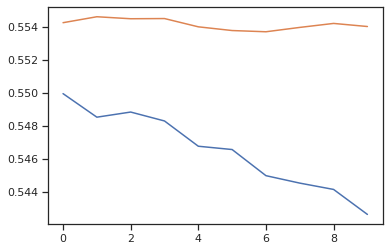

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [51]:
y_predict_pred= nets_2.predict(predict_ds )
y_predict_pred

array([[0.26831216],
       [0.3724402 ],
       [0.39310744],
       ...,
       [0.04657578],
       [0.1786659 ],
       [0.0831584 ]], dtype=float32)

In [52]:
res_df = pd.DataFrame({'id': test_set.id, 'label': y_predict_pred.reshape(y_predict_pred.shape[0])})
res_df.to_csv('submission.csv', index=False)